In [0]:
# Use legacy timestamp parser for Spark 3.x compatibility
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


In [0]:
df = spark.read.option("header", True)\
    .option("sep", ";")\
    .option("inferSchema", True)\
    .csv("/FileStore/tables/household_power_consumption.txt")

df.show(5)


+----------+--------+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|      Date|    Time|Global_active_power|Global_reactive_power|Voltage|Global_intensity|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+----------+--------+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|16/12/2006|17:24:00|              4.216|                0.418|234.840|          18.400|         0.000|         1.000|          17.0|
|16/12/2006|17:25:00|              5.360|                0.436|233.630|          23.000|         0.000|         1.000|          16.0|
|16/12/2006|17:26:00|              5.374|                0.498|233.290|          23.000|         0.000|         2.000|          17.0|
|16/12/2006|17:27:00|              5.388|                0.502|233.740|          23.000|         0.000|         1.000|          17.0|
|16/12/2006|17:28:00|              3.666|                0.528

In [0]:
from pyspark.sql.functions import concat_ws, to_timestamp, col

# Reload cleanly
df = spark.read.option("header", True)\
    .option("sep", ";")\
    .csv("/FileStore/tables/household_power_consumption.txt")

# Correctly parse timestamp and cast power usage
df = df.withColumn("Timestamp", to_timestamp(concat_ws(" ", col("Date"), col("Time")), "dd/MM/yyyy HH:mm:ss")) \
       .withColumn("Global_active_power", col("Global_active_power").cast("double")) \
       .dropna(subset=["Timestamp", "Global_active_power"])

# Check output
df.select("Date", "Time", "Timestamp", "Global_active_power").show(5, truncate=False)


+----------+--------+-------------------+-------------------+
|Date      |Time    |Timestamp          |Global_active_power|
+----------+--------+-------------------+-------------------+
|16/12/2006|17:24:00|2006-12-16 17:24:00|4.216              |
|16/12/2006|17:25:00|2006-12-16 17:25:00|5.36               |
|16/12/2006|17:26:00|2006-12-16 17:26:00|5.374              |
|16/12/2006|17:27:00|2006-12-16 17:27:00|5.388              |
|16/12/2006|17:28:00|2006-12-16 17:28:00|3.666              |
+----------+--------+-------------------+-------------------+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import hour, avg

hourly_usage = df.withColumn("hour", hour("Timestamp")) \
                 .groupBy("hour") \
                 .agg(avg("Global_active_power").alias("avg_power"))

hourly_usage.show(24)


+----+-------------------+
|hour|          avg_power|
+----+-------------------+
|  12| 1.2070750260792096|
|  22| 1.4126147300503793|
|   1| 0.5393251638576786|
|  13| 1.1445321537379893|
|   6| 0.7915996434393993|
|  16| 0.9489045760824987|
|   3| 0.4448663201760571|
|  20|  1.899064135957484|
|   5|0.45367353976073366|
|  19| 1.7333350634775906|
|  15| 0.9907604535126148|
|  17|  1.055109358520638|
|   9| 1.3316453420225987|
|   4| 0.4438472520130822|
|   8| 1.4610164956914231|
|  23| 0.9021416082281435|
|   7| 1.5022463299094788|
|  10| 1.2606274399399375|
|  21| 1.8776974593412747|
|  11| 1.2458220016891879|
|  14| 1.0828393185410712|
|   2| 0.4806205596975625|
|   0| 0.6594341860546722|
|  18| 1.3264510996285734|
+----+-------------------+



In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

vec_assembler = VectorAssembler(inputCols=["avg_power"], outputCol="features")
features_df = vec_assembler.transform(hourly_usage)

kmeans = KMeans(k=3, seed=42)
model = kmeans.fit(features_df)
clustered_df = model.transform(features_df)

clustered_df.select("hour", "avg_power", "prediction").orderBy("hour").show()


+----+-------------------+----------+
|hour|          avg_power|prediction|
+----+-------------------+----------+
|   0| 0.6594341860546722|         1|
|   1| 0.5393251638576786|         1|
|   2| 0.4806205596975625|         1|
|   3| 0.4448663201760571|         1|
|   4| 0.4438472520130822|         1|
|   5|0.45367353976073366|         1|
|   6| 0.7915996434393993|         1|
|   7| 1.5022463299094788|         0|
|   8| 1.4610164956914231|         0|
|   9| 1.3316453420225987|         0|
|  10| 1.2606274399399375|         0|
|  11| 1.2458220016891879|         0|
|  12| 1.2070750260792096|         0|
|  13| 1.1445321537379893|         0|
|  14| 1.0828393185410712|         0|
|  15| 0.9907604535126148|         0|
|  16| 0.9489045760824987|         0|
|  17|  1.055109358520638|         0|
|  18| 1.3264510996285734|         0|
|  19| 1.7333350634775906|         2|
+----+-------------------+----------+
only showing top 20 rows



In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

vec_assembler = VectorAssembler(inputCols=["avg_power"], outputCol="features")
features_df = vec_assembler.transform(hourly_usage)

kmeans = KMeans(k=3, seed=42)
model = kmeans.fit(features_df)
clustered_df = model.transform(features_df)

clustered_df.select("hour", "avg_power", "prediction").orderBy("hour").show()


+----+-------------------+----------+
|hour|          avg_power|prediction|
+----+-------------------+----------+
|   0| 0.6594341860546722|         1|
|   1| 0.5393251638576786|         1|
|   2| 0.4806205596975625|         1|
|   3| 0.4448663201760571|         1|
|   4| 0.4438472520130822|         1|
|   5|0.45367353976073366|         1|
|   6| 0.7915996434393993|         1|
|   7| 1.5022463299094788|         0|
|   8| 1.4610164956914231|         0|
|   9| 1.3316453420225987|         0|
|  10| 1.2606274399399375|         0|
|  11| 1.2458220016891879|         0|
|  12| 1.2070750260792096|         0|
|  13| 1.1445321537379893|         0|
|  14| 1.0828393185410712|         0|
|  15| 0.9907604535126148|         0|
|  16| 0.9489045760824987|         0|
|  17|  1.055109358520638|         0|
|  18| 1.3264510996285734|         0|
|  19| 1.7333350634775906|         2|
+----+-------------------+----------+
only showing top 20 rows



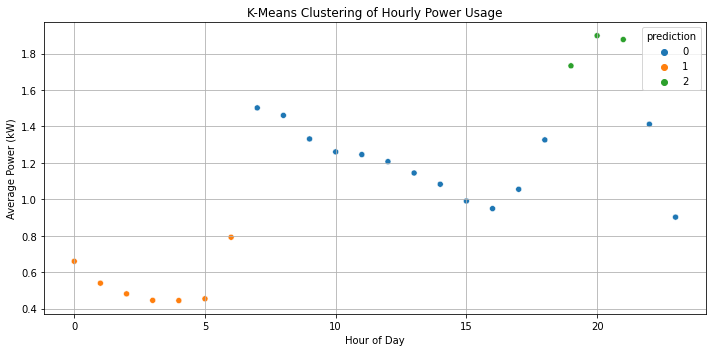

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert clustered_df (Spark DataFrame) to Pandas
pdf = clustered_df.select("hour", "avg_power", "prediction").toPandas()

# Now plot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=pdf, x="hour", y="avg_power", hue="prediction", palette="tab10")
plt.title("K-Means Clustering of Hourly Power Usage")
plt.xlabel("Hour of Day")
plt.ylabel("Average Power (kW)")
plt.grid(True)
plt.tight_layout()
plt.show()
